## STMO Project

In [1]:
import osmnx as ox
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from ipywidgets import interact, IntSlider

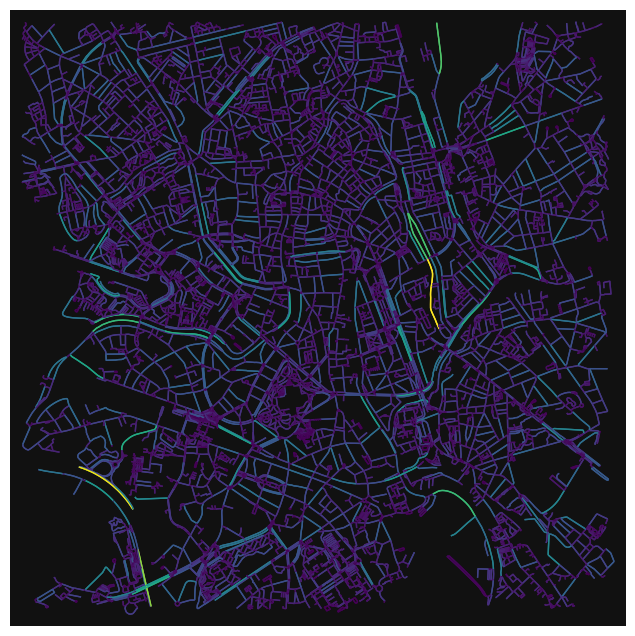

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [95]:
# Define the address as a starting point
center = "Sint-kwintensberg 74, Ghent, Belgium"
geolocator = Nominatim(user_agent="STMO_project")

# Geocode the address to get its latitude and longitude
center_point = ox.geocode(center)

# Define the buffer distance (in meters) for the map area
buffer_distance = 2500  # Meters radius from center point

# Download the street network data within the buffer distance around the center point
graph = ox.graph_from_point(center_point, dist=buffer_distance, network_type='walk')
graph = ox.distance.add_edge_lengths(graph)

# Plot the graph to verify
ec = ox.plot.get_edge_colors_by_attr(graph, attr='length')
ox.plot_graph(graph, edge_color=ec, node_alpha=0)

In [96]:
city_nodes, city_edges = ox.graph_to_gdfs(graph)
city_nodes

,y,x,street_count,highway,railway,ref,geometry
osmid,,,,,,,
145763,51.031829,3.732254,3,NaN,NaN,NaN,POINT (3.73225 51.03183)
145785,51.038644,3.725182,3,NaN,NaN,NaN,POINT (3.72518 51.03864)
145786,51.039828,3.723309,4,NaN,NaN,NaN,POINT (3.72331 51.03983)
145787,51.039805,3.722999,3,NaN,NaN,NaN,POINT (3.723 51.03981)
145789,51.053930,3.730887,4,NaN,NaN,NaN,POINT (3.73089 51.05393)
...,...,...,...,...,...,...,...
12400928610,51.063653,3.726471,1,NaN,NaN,NaN,POINT (3.72647 51.06365)
12400928611,51.063710,3.726773,1,NaN,NaN,NaN,POINT (3.72677 51.06371)
12404997224,51.063142,3.688887,3,NaN,NaN,NaN,POINT (3.68889 51.06314)


In [97]:
city_edges.name

u            v            key
145763       10608884795  0      [Achilles Heyndrickxlaan, Burggravenlaan]
             1679740532   0                                 Burggravenlaan
             11958115602  0                                 Burggravenlaan
145785       31366176     0                            Fernand Scribedreef
             1788439106   0                        Charles de Kerchovelaan
                                                   ...                    
12431009937  12315769314  0                                            NaN
             12431009938  0                                            NaN
12431009938  9626499411   0                                            NaN
             12431009937  0                                            NaN
             9626499406   0                                            NaN
Name: name, Length: 28350, dtype: object

In [5]:
def translate_address(graph, geolocator, address: str, return_coords=False):
    """
    Translate an address to a corresponding node in the specified graph.

    Parameters:
    ----------
    graph : networkx.MultiDiGraph
        The graph network to search, typically an OSMnx graph.
    geolocator : geopy.geocoders
        The geolocator instance used to geocode the address.
    address : str
        A valid address that is expected to correspond to a location within the graph.
    return_coords : bool, optional
        If True, returns the coordinates of the node along with the node object. Default is False.

    Returns:
    -------
    node : int
        The nearest node's osmid in the graph.
    start_lon : float
        Longitude of the nearest node (only if return_coords=True).
    start_lat : float
        Latitude of the nearest node (only if return_coords=True).

    Raises:
    ------
    AssertionError
        If the address cannot be located or mapped to a node in the graph.
    """

    # Geocode the address to get latitude and longitude
    location = geolocator.geocode(address)
    if location is None:
        raise ValueError(f"Address '{address}' could not be geocoded.")

    start_lat, start_lon = location.latitude, location.longitude

    # Find the nearest node in the graph
    node = ox.distance.nearest_nodes(graph, X=start_lon, Y=start_lat)
    if node is None:
        raise ValueError("No nearest node found in the graph for the given address.")

    if return_coords:
        return node, (start_lon, start_lat)
    else:
        return node


Number of possible nodes 410


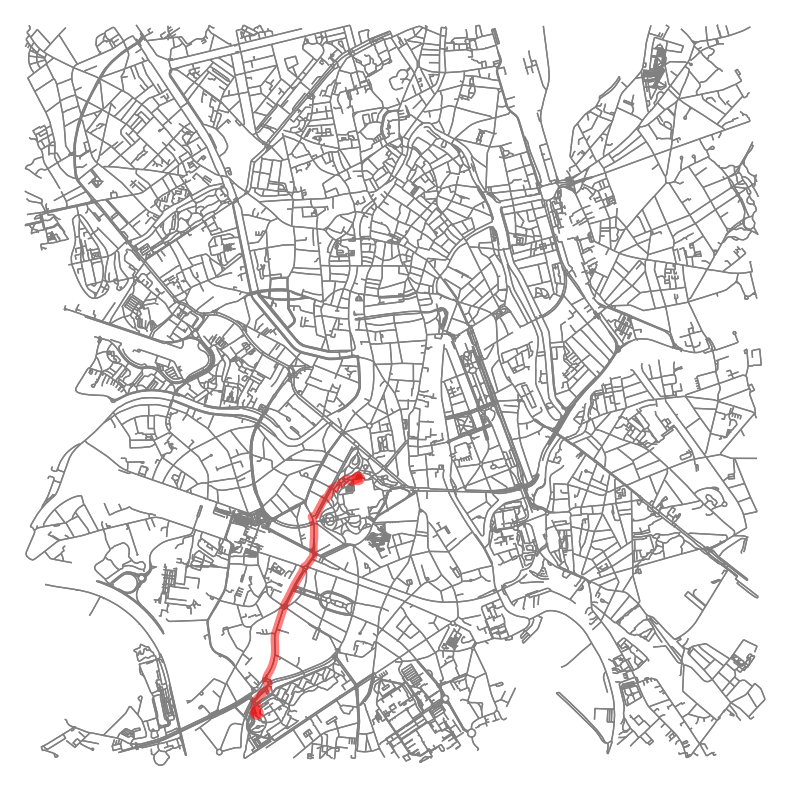

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [98]:
# Define a start address:
start_address = "Eugene-felixdreef 1, ghent Belgium"

start_node = translate_address(graph, geolocator, start_address, False)

# Run Dijkstra's algorithm to get the shortest paths from the start node
distances, predecessors = nx.single_source_dijkstra(graph, source=start_node, weight='length')  # 'length' is the edge attribute for distance

# Set target distance (5 km)
target_distance = 2000  # in meters
threshold = 50  # in meters (± 50 meters)

# Filter nodes that are within the threshold distance
close_nodes = {node: distance for node, distance in distances.items() if abs(distance - target_distance) <= threshold}
print("Number of possible nodes", len(close_nodes))

# Select a target node, the one that is about 5 km away (choose any from close_nodes)
target_node = list(close_nodes.keys())[0]  # Select the first node (or choose based on your preference)

# Get the specific route between start_node and target_node
route = nx.shortest_path(graph, source=start_node, target=target_node, weight='length')

# Print the nodes along the route
#print("Route from start to target (in kilometers):")
#for node in route:
#    print(node, distances[node])

# Visualize the route on the map
fig, ax = plt.subplots(figsize=(10, 10))
# Plot the full graph
ox.plot_graph(graph, ax=ax, node_size=0, edge_color='gray', bgcolor='white', show=False)
# Plot the specific route
ox.plot_graph_route(graph, route, route_linewidth=6, node_size=0, bgcolor='white', ax=ax, show=True)

# You can save the plot to a file if needed
# plt.savefig('route_map.png', dpi=300)


In [ ]:
#distances

{6627642399: 0,
 5578261575: 3.690907321236429,
 5578261551: 12.35580615639142,
 5578261573: 12.666631924400438,
 5578261560: 12.926363862607257,
 5578261562: 13.119274161429304,
 5578261557: 15.617008264243246,
 5578261552: 15.69212758148202,
 5578261570: 15.82013531194997,
 5578261564: 15.961038984689363,
 5578261556: 18.320413191042487,
 5578261566: 18.62776611869348,
 2479402628: 22.454768168514487,
 2526655558: 22.79491445162077,
 2479402644: 26.600725734060113,
 1242340327: 27.0454145598626,
 5872457948: 27.63804041531465,
 5872457943: 27.780679670116616,
 256261687: 29.836424951148743,
 5578261558: 30.19354027793985,
 5578261571: 30.238325977618434,
 3387829955: 30.471712734457,
 6627642405: 30.66771833190442,
 5578261565: 30.688472004076786,
 2526655565: 32.70080434559793,
 5578261567: 33.27299573078651,
 6627642403: 43.82417378669312,
 1242340278: 45.44018928601538,
 3387829958: 48.12445951485364,
 4764798714: 53.99302327061317,
 4564274717: 55.69595531529863,
 1242340259: 59.

In [89]:
city_edges


osmid  \
u           v           key                                                      
145715      56537191    0                                             19207591   
            205294656   0          [307416345, 1066966715, 19207590, 19207591]   
            2040932329  0                    [116181305, 233511331, 262472955]   
145763      10608884795 0    [237303363, 658608134, 242016456, 12141436, 12...   
            1679740532  0                               [713177181, 242016455]   
...                                                                        ...   
12431009937 12315769314 0                                           1179680655   
            12431009938 0                                           1343500800   
12431009938 9626499411  0                                           1046842512   
            12431009937 0                                           1343500800   
            9626499406  0                                           1046842512   

                                highway   lanes maxspeed  \
u           v           key                                
145715      56537191    0         trunk       2       90   
            205294656   0         trunk       2       90   
            2040932329  0    trunk_link       2       70   
145763      10608884795 0      tertiary       2       50   
            1679740532  0      tertiary  [2, 3]       50   
...                                 ...     ...      ...   
12431009937 12315769314 0       footway     NaN      NaN   
            12431009938 0       footway     NaN      NaN   
12431009938 9626499411  0       footway     NaN      NaN   
            12431009937 0       footway     NaN      NaN   
            9626499406  0       footway     NaN      NaN   

                                                                      name  \
u           v           key                                                  
145715      56537191    0                            Binnenring-Zwijnaarde   
            205294656   0    [Binnenring Merelbeke, Binnenring-Zwijnaarde]   
            2040932329  0                                              NaN   
145763      10608884795 0        [Achilles Heyndrickxlaan, Burggravenlaan]   
            1679740532  0                                   Burggravenlaan   
...                                                                    ...   
12431009937 12315769314 0                                              NaN   
            12431009938 0                                              NaN   
12431009938 9626499411  0                                              NaN   
            12431009937 0                                              NaN   
            9626499406  0                                              NaN   

                             oneway  ref reversed      length  \
u           v           key                                     
145715      56537191    0     False   R4    False  212.106300   
            205294656   0     False   R4     True  923.740001   
            2040932329  0     False  NaN    False  138.546316   
145763      10608884795 0     False  NaN     True  305.044403   
            1679740532  0     False  NaN    False  143.045927   
...                             ...  ...      ...         ...   
12431009937 12315769314 0     False  NaN     True    3.644047   
            12431009938 0     False  NaN    False   18.665499   
12431009938 9626499411  0     False  NaN    False    8.484826   
            12431009937 0     False  NaN     True   18.665499   
            9626499406  0     False  NaN     True   27.696130   

                                                                      geometry  \
u           v           key                                                      
145715      56537191    0    LINESTRING (3.73459 51.01288, 3.73236 51.01351...   
            205294656   0    LINESTRING (3.73459 51.01288, 3.73539 51.0127,...   
            2040932329  0    LINESTR

In [90]:
#close_nodes

In [91]:
# Points of interest: Gravensteen: Sint-Veerleplein 11 9000 Gent, Museum of industry: Minnemeers 10, Flowrts for sint rita: Sint-Margrietstraat, Lievekaai
# Define the addresses
addresses = {
    "Gravensteen": "Sint-Veerleplein 11, 9000 Gent, Belgium",
    "Museum of Industry": "Minnemeers 10, 9000 Gent, Belgium",
    "Sint Rita": "Sint-Margrietstraat 1, 9000 Gent, Belgium", 
    "Lievekaai": "Lievekaai 1, 9000 Gent, Belgium",
    "St. Bavo's Cathedral": "Sint-Baafsplein, 9000 Gent, Belgium",
    "Ghent University Botanical Garden": "Karel Lodewijk Ledeganckstraat 35, 9000 Gent, Belgium",
    "STAM Ghent City Museum": "Godshuizenlaan 2, 9000 Gent, Belgium",
    "Design Museum Gent": "Jan Breydelstraat 5, 9000 Gent, Belgium",
    "Citadelpark": "Citadelpark, 9000 Gent, Belgium",
    "Korenmarkt": "Korenmarkt, 9000 Gent, Belgium",
    "The House of Alijn": "Kraanlei 65, 9000 Gent, Belgium",
    "SMAK Museum of Contemporary Art": "Jan Hoetplein 1, 9000 Gent, Belgium"
}

predefined_coords = {
    "Gravensteen": (51.056279, 3.720084),
    "Museum of Industry": (51.063314, 3.728368),
    "Sint Rita": (51.047553, 3.717246),
    "Lievekaai": (51.056810, 3.721897),
    "St. Bavo's Cathedral": (51.053541, 3.725765),
    "Ghent University Botanical Garden": (51.030263, 3.710734),
    "STAM Ghent City Museum": (51.046202, 3.721773),
    "Design Museum Gent": (51.054369, 3.718559),
    "Citadelpark": (51.036299, 3.718643),
    "Korenmarkt": (51.053949, 3.720967),
    "The House of Alijn": (51.056587, 3.721885),
    "SMAK Museum of Contemporary Art": (51.037662, 3.710559)
}


## Genetic Algorithm Implementation

In [11]:
# Fitness Function
# The fitness function evaluates how close the total length of a path is to the target distance
def fitness(graph, path, target_distance):
    path_length = sum(
        nx.shortest_path_length(graph, path[i], path[i + 1], weight='length')
        for i in range(len(path) - 1)
    )
    # Penalize paths that exceed the target distance
    return -abs(target_distance - path_length) - (0.1 * max(0, path_length - target_distance))


In [12]:
# Crossover
# Combine two parent paths to create an offspring path
def crossover(parent1, parent2):
    split_idx = random.randint(1, len(parent1) - 2)
    child = parent1[:split_idx] + [node for node in parent2 if node not in parent1[:split_idx]]
    return child

In [13]:
# Mutation
# Introduce small changes to paths
def mutate(path):
    idx1, idx2 = random.sample(range(1, len(path) - 1), 2)  # Avoid start node
    path[idx1], path[idx2] = path[idx2], path[idx1]
    return path

In [14]:
# Initialize Population
# Generate random paths:
def initialize_population(nodes, population_size):
    population = []
    for _ in range(population_size):
        path = nodes[1:]  # Exclude the start node
        random.shuffle(path)
        path = [nodes[0]] + path  # Add start node back
        population.append(path)
    return population

In [111]:
def genetic_algorithm(graph, nodes, start_node, target_distance, mutation_rate=0.1, allow_vertex_reuse=False, population_size=100, generations=200, early_stopping_rounds=10, verbose=0):
    nodes = list(start_node.values()) + list(nodes.values())  # Include start node
    population = initialize_population(nodes, population_size)
    history = []  # To store the best path of each generation
    best_lengths = []  # To store the best lengths of each generation
    best_path = None
    best_length = float('inf')
    no_improvement_rounds = 0  # Counter for early stopping

    for generation in range(generations):
        # Evaluate fitness
        population_fitness = []
        for path in population:
            # Enforce the no-reuse constraint if needed
            if not allow_vertex_reuse and len(set(path)) != len(path):
                fitness_value = float('-inf')  # Penalize paths that reuse vertices
                print("I just avoided a vertex reuse! Yippie")
            else:
                fitness_value = fitness(graph, path, target_distance)
            population_fitness.append((path, fitness_value))

        # Sort by fitness descending
        population_fitness.sort(key=lambda x: x[1], reverse=True)

        # Save the best path of this generation
        current_best_path, _ = population_fitness[0]
        history.append(current_best_path)

        # Calculate the best length of this generation
        current_length = sum(
            nx.shortest_path_length(graph, current_best_path[i], current_best_path[i + 1], weight='length')
            for i in range(len(current_best_path) - 1)
        )
        best_lengths.append(current_length)

        # Update the best path and length if current path is better
        if abs(target_distance - current_length) < abs(target_distance - best_length):
            best_path = current_best_path
            best_length = current_length
            no_improvement_rounds = 0  # Reset early stopping counter
        else:
            no_improvement_rounds += 1

        # Check for early stopping
        if no_improvement_rounds >= early_stopping_rounds:
            print(f"Early stopping at generation {generation + 1} due to no improvement in last {early_stopping_rounds} generations.")
            break
        
        if verbose == 1:
            print(f"Generation: [{generation+1}/{generations}] --- Best path: {population_fitness[0][0]} with length: {best_length}")
        else:
            print(f"Generation: [{generation+1}/{generations}] --- Best length: {best_length}")

        # Select parents
        parents = [path for path, _ in population_fitness[:population_size // 2]]

        # Generate next generation
        next_generation = parents[:]
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(parents, 2)
            child = crossover(parent1, parent2)
            if random.random() < mutation_rate:  # Mutation probability
                child = mutate(child)
            next_generation.append(child)

        population = next_generation

    return best_path, best_length, history, best_lengths


In [ ]:
nodes_to_visit = dict()

for monument in addresses.keys():
    current = addresses[monument]
    nodes_to_visit[monument] = translate_address(graph, geolocator, current, False)

print("Nodes dict:", nodes_to_visit)

In [43]:
nodes_to_visit = {name: ox.distance.nearest_nodes(graph, coord[1], coord[0]) for name, coord in predefined_coords.items()}

In [99]:
# Define the graph and nodes
start_address = "Eugene-felixdreef 1, ghent Belgium"
start_node = {start_address: translate_address(graph, geolocator, start_address, False)}


# Run GA
target_distance = 15000  # Target distance in meters
best_path, best_length, history, best_lengths = genetic_algorithm(graph = graph, 
                                                                  nodes = nodes_to_visit, 
                                                                  start_node = start_node, 
                                                                  target_distance = target_distance, 
                                                                  generations = 100, population_size=100, 
                                                                  mutation_rate=0.5, early_stopping_rounds=15,
                                                                  allow_vertex_reuse=False)

print("Best Path:", best_path)
print("Path Length:", best_length)

Generation: [1/100] --- Best length: 14915.493153179581
Generation: [2/100] --- Best length: 14921.149545052018
Generation: [3/100] --- Best length: 14921.149545052018
Generation: [4/100] --- Best length: 15055.108885423362
Generation: [5/100] --- Best length: 14973.530478999559
Generation: [6/100] --- Best length: 14973.530478999559
Generation: [7/100] --- Best length: 15006.196485805656
Generation: [8/100] --- Best length: 15006.196485805656
Generation: [9/100] --- Best length: 15006.196485805656
Generation: [10/100] --- Best length: 15006.196485805656
Generation: [11/100] --- Best length: 15006.196485805656
Generation: [12/100] --- Best length: 15006.196485805656
Generation: [13/100] --- Best length: 15006.196485805656
Generation: [14/100] --- Best length: 15006.196485805656
Generation: [15/100] --- Best length: 15006.196485805656
Generation: [16/100] --- Best length: 15006.196485805656
Generation: [17/100] --- Best length: 14999.61773312795
Generation: [18/100] --- Best length: 149

In [83]:
def plot_path(graph, path, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    # Plot the base graph
    ox.plot_graph(graph, ax=ax, show=False, close=False, bgcolor='white', edge_color='black', node_color='white', node_size=1, edge_linewidth=0.5)

    # Gather all edges for the path
    edges = []
    for i in range(len(path) - 1):
        route = nx.shortest_path(graph, path[i], path[i + 1], weight='length')
        edges += list(zip(route[:-1], route[1:]))
    
    # Get node coordinates for plotting
    node_positions = {node: (graph.nodes[node]['x'], graph.nodes[node]['y']) for node in graph.nodes}
    edge_positions = [(node_positions[edge[0]], node_positions[edge[1]]) for edge in edges]

    # Plot the path edges
    for start, end in edge_positions:
        ax.plot([start[0], end[0]], [start[1], end[1]], color='red', linewidth=2, zorder=3)

    # Highlight the nodes in the path
    path_coords = [node_positions[node] for node in path]
    path_x, path_y = zip(*path_coords)
    ax.scatter(path_x, path_y, color='blue', s=50, zorder=4)

    # Annotate nodes
    for idx, (x, y) in enumerate(path_coords):
        ax.text(x, y, str(idx), fontsize=6, ha='center', va='center', color='black', zorder=5)

    ax.set_title("Path Visualization on Graph")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


In [118]:
from ipywidgets import interact, IntSlider

def visualize_GA(graph, history, best_lengths, target_distance):
    @interact(generation=IntSlider(min=0, max=len(history)-1, step=1, value=len(history)-1))
    def show_generation(generation):
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

        # Plot the graph and path for the selected generation
        plot_path(graph, history[generation], ax=ax1)
        ax1.set_title(f"Generation: {generation}, Best Length: {best_lengths[generation]:.2f}")

        # Plot the best lengths up to the current generation
        ax2.plot(range(1, len(best_lengths) + 1), best_lengths, linestyle='-', color='blue', label='Best Lengths')
        ax2.scatter(generation + 1, best_lengths[generation], color='red', s=100, zorder=3, label='Selected Generation')
        ax2.axvline(x=generation + 1, color='red', linestyle='--', linewidth=1)
        ax2.axhline(y=target_distance, color='green', linestyle='--', linewidth=2, label='Target Distance')

        # Dynamically set y-axis limits to include target_distance and best_lengths
        min_y = min(min(best_lengths), target_distance) * 0.95
        max_y = max(max(best_lengths), target_distance) * 1.05
        ax2.set_ylim(min_y, max_y)

        # Customize the plot
        ax2.set_xlim(1, len(best_lengths))
        ax2.set_title("Best Path Lengths Across Generations")
        ax2.set_xlabel("Generation")
        ax2.set_ylabel("Best Path Length")
        ax2.legend()
        ax2.grid()

        plt.tight_layout()
        plt.show()


In [105]:
visualize_GA(graph, history, best_lengths, target_distance)

interactive(children=(IntSlider(value=31, description='generation', max=31), Output()), _dom_classes=('widget-…

### Random points of interest in the graph

In [108]:
def generate_random_node(graph, num_nodes=10):
    # Get a list of all nodes in the graph
    all_nodes = list(graph.nodes)
    
    # Randomly sample the desired number of nodes
    random_nodes = random.sample(all_nodes, num_nodes)
    
    # Create a dictionary with descriptive keys
    random_nodes_dict = {f"Node {i+1}": node for i, node in enumerate(random_nodes)}
    
    return random_nodes_dict

random_nodes = generate_random_node(graph, num_nodes=10)
print("Randomly selected nodes:", random_nodes)

Randomly selected nodes: {'Node 1': 263516824, 'Node 2': 246844623, 'Node 3': 6421147306, 'Node 4': 3349712721, 'Node 5': 431872667, 'Node 6': 510815805, 'Node 7': 12177290586, 'Node 8': 6122791864, 'Node 9': 1131245343, 'Node 10': 10962332727}


In [112]:
# Define the graph and nodes
start_node = generate_random_node(graph, num_nodes=1)

# Run GA
target_distance = 15000  # Target distance in meters
best_path, best_length, history, best_lengths = genetic_algorithm(graph = graph, 
                                                                  nodes = random_nodes, 
                                                                  start_node = start_node, 
                                                                  target_distance = target_distance, 
                                                                  generations = 100, population_size=100, 
                                                                  mutation_rate=0.5, early_stopping_rounds=25,
                                                                  allow_vertex_reuse=False)

print("Best Path:", best_path)
print("Path Length:", best_length)

Generation: [1/100] --- Best length: 24748.73563747743
Generation: [2/100] --- Best length: 24748.73563747743
Generation: [3/100] --- Best length: 21435.737133306226
Generation: [4/100] --- Best length: 21435.737133306226
Generation: [5/100] --- Best length: 21435.737133306226
Generation: [6/100] --- Best length: 20376.062774204314
Generation: [7/100] --- Best length: 20376.062774204314
Generation: [8/100] --- Best length: 19226.20946109982
Generation: [9/100] --- Best length: 19226.20946109982
Generation: [10/100] --- Best length: 19226.20946109982
Generation: [11/100] --- Best length: 19089.550493880626
Generation: [12/100] --- Best length: 17849.437351832294
Generation: [13/100] --- Best length: 17849.437351832294
Generation: [14/100] --- Best length: 17849.437351832294
Generation: [15/100] --- Best length: 17849.437351832294
Generation: [16/100] --- Best length: 17849.437351832294
Generation: [17/100] --- Best length: 17361.709093811834
Generation: [18/100] --- Best length: 17361.7

In [119]:
visualize_GA(graph, history, best_lengths, target_distance=target_distance)

interactive(children=(IntSlider(value=31, description='generation', max=31), Output()), _dom_classes=('widget-…